In [1]:
import os
import numpy as np
import torch
import cv2 as cv
import matplotlib.pyplot as plt
from llm.chat import create_answer
from object_detection.yolo_object_detection import object_detection
from activity_model.sequential.model import LSTMClassifier
from activity_model.non_sequential.model import ANN
from activity_model.ensemble import Ensemble
import hand_landmarks.detect_hand_landmarks as hl

Ultralytics YOLOv8.0.178  Python-3.9.12 torch-2.0.1+cpu CPU (Intel Core(TM) i7-10610U 1.80GHz)
Setup complete  (8 CPUs, 15.6 GB RAM, 268.9/953.1 GB disk)


In [2]:
sequential_model = LSTMClassifier(1000, 3, 512, 8)
non_sequential_model = ANN(858, 8)

sequential_state_dict = torch.load("activity_model/sequential_model_params.pth", map_location=torch.device('cpu'))
non_sequential_state_dict = torch.load("activity_model/non_sequential_model_params_v2.pth", map_location=torch.device('cpu'))

sequential_model.load_state_dict(sequential_state_dict)
non_sequential_model.load_state_dict(non_sequential_state_dict)

<All keys matched successfully>

In [3]:
ensemble = Ensemble(sequential_model, non_sequential_model)

In [28]:
test_folder_path = os.path.join(os.getcwd(), "test_data")

In [43]:
object_det_model_params = os.path.join(os.getcwd(), "object_detection", "weights", "best.pt")
object_det_output = object_detection(img_dir=test_folder_path, model_dir=object_det_model_params, conf=0.5, save=True)
print(object_det_output)


0: 384x640 3 legs, 1 tableplate, 1 left_hand, 1 right_hand, 1 screwdriver, 1 drill, 1: 384x640 4 legs, 1 tableplate, 1 left_hand, 1 right_hand, 1 screwdriver, 1 drill, 2: 384x640 2 legs, 1 tableplate, 1 left_hand, 1 right_hand, 1 screwdriver, 1 drill, 4432.5ms
Speed: 5.2ms preprocess, 1477.5ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to yolo_predictions\predict


[{'file_name': '00041.jpg', 'bb_info': [[180, 301, 178, 176], [587, 196, 133, 145], [362, 252, 312, 160], [422, 361, 842, 237], [783, 228, 138, 292], [16, 399, 32, 156], [711, 325, 277, 309], [711, 324, 277, 310]], 'object_classes': [4, 5, 0, 1, 0, 0, 3, 2]}, {'file_name': '00043.jpg', 'bb_info': [[311, 158, 162, 124], [655, 259, 213, 249], [728, 350, 247, 257], [506, 293, 685, 296], [482, 134, 286, 110], [133, 292, 81, 285], [67, 430, 130, 97], [96, 350, 192, 176], [836, 88, 32, 138]], 'object_classes': [4, 5, 3, 1, 0, 0, 2, 0, 0]}, {'file_name': '00045.jpg', 'bb_info': [[736, 345, 231, 268], [469, 54, 170, 103], [679, 267, 218, 258], [200, 156, 274, 259], [577, 222, 549, 230], [230, 336, 107, 284], [655, 53, 309, 81]], 'object_classes': [3, 4, 5, 0, 1, 2, 0]}]


Example output of object detection model

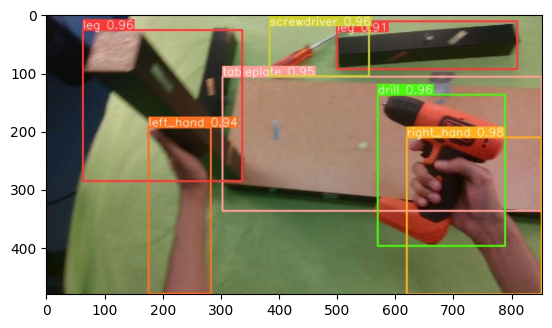

In [49]:
yolo_out_folders = os.listdir("yolo_predictions")
yolo_out_dir = os.path.join("yolo_predictions", yolo_out_folders[0])
yolo_out_dir = os.path.join(yolo_out_dir, "00045.jpg")
img = cv.cvtColor(cv.imread(yolo_out_dir), cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

Hand landmarks

Before: 
736 345 231 268
After correction: 
620 851 211 479
Before: 
230 336 107 284
After correction: 
176 283 194 478
Length of landmarks vector: 42


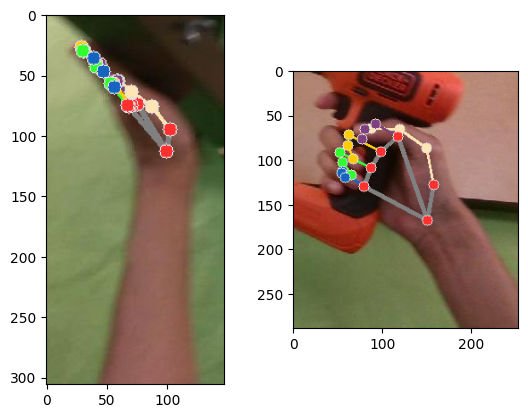

In [48]:
test_image_path = os.path.join(test_folder_path, "00045.jpg")
hl_data = hl.detect(cv.imread(test_image_path), object_det_output[2])

Ensemble model

In [50]:
predictions = ensemble.predict(test_folder_path, object_det_output, prob=True)

c:\Users\Zaman\Documents\GitHub Repos\project-jarvis\.venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [51]:
ensemble.vote()

'use drill'

LLM response

In [3]:
vector_index = os.path.join("chat", "data", "vector_index.json")
response = create_answer(vector_index, ensemble.vote())
print(response)

Next Action is:
Drop Tool, Instructions:
- lay down the tool you used in order to continue with the next leg
